# CSGO Round Snapshot Models #
#### In this notebook I will be running RF,DT,LR,GBM,kNN, and SVM models, gathering their performance metrics and compiling them into one graphic to select the best model. ####
### File I/O, Importing Packages and Data Cleaning ###

In [24]:
# Helper packages.
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt                     
import numpy as np
import math
# Scikit-learn packages for building models and model evaluation.
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import scale,StandardScaler
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from textwrap import wrap

np.random.seed(1)
rounds = pd.read_csv("C:/Users/cokeo/OneDrive/Documents/csgo_round_snapshots.csv")
rounds.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [25]:
rounds.shape

(122410, 97)

In [26]:
# Convert CT/T Round Wins  to 0/1 values
rounds['round_winner'] = np.where(rounds['round_winner'] == 'CT',0,1 )
# Check for NAs.
print(rounds.isnull().sum())

time_left                    0
ct_score                     0
t_score                      0
map                          0
bomb_planted                 0
                            ..
ct_grenade_molotovgrenade    0
t_grenade_molotovgrenade     0
ct_grenade_decoygrenade      0
t_grenade_decoygrenade       0
round_winner                 0
Length: 97, dtype: int64


In [27]:
# Select the predictors and target.
#Encoded the maps as dummy variables
X = rounds.drop(['round_winner',], axis = 1)
X = pd.get_dummies(X, columns = ['map'], dtype=float, drop_first=True)
y = np.array(rounds['round_winner'])
# Set the seed to 1.
np.random.seed(1)
# Split into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [28]:
def get_performance_scores(y_test, y_predict, y_predict_prob, eps=1e-15, beta=0.5):
    from sklearn import metrics
    # Scores keys.
    metric_keys = ["accuracy", "precision", "recall", "f1", "fbeta", "log_loss", "AUC"]
    # Score values.
    metric_values = [None]*len(metric_keys)
    metric_values[0] = metrics.accuracy_score(y_test, y_predict)
    metric_values[1] = metrics.precision_score(y_test, y_predict)
    metric_values[2] = metrics.recall_score(y_test, y_predict)
    metric_values[3] = metrics.f1_score(y_test, y_predict)
    metric_values[4] = metrics.fbeta_score(y_test, y_predict, beta=beta)
    metric_values[5] = metrics.log_loss(y_test, y_predict_prob[:, 1], eps=eps)
    metric_values[6] = metrics.roc_auc_score(y_test, y_predict_prob[:, 1])
    perf_metrics = dict(zip(metric_keys, metric_values))
    return(perf_metrics)

### Random Forest ###

In [29]:
forest = RandomForestClassifier(criterion = 'gini', n_estimators = 100, 
                                  random_state = 1)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [30]:
# Predict on test data.
forest_y_predict = forest.predict(X_test)
# Look at the first few predictions.
print(forest_y_predict[0:5, ])

[1 0 1 0 1]


In [31]:
# Predict on test, but instead of labels we will get probabilities for class 0 and 1.
forest_y_predict_prob = forest.predict_proba(X_test) 
print(forest_y_predict_prob[5:])

[[0.44 0.56]
 [0.94 0.06]
 [0.6  0.4 ]
 ...
 [0.46 0.54]
 [0.96 0.04]
 [0.01 0.99]]


In [32]:
forest_scores = get_performance_scores(y_test, forest_y_predict, forest_y_predict_prob)
metrics_forest = {"RF": forest_scores}

### Logistic Regression ###

In [33]:
# Scale the features.
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up logistic regression model.
logistic_regression_model = linear_model.LogisticRegression(max_iter=500)
print(logistic_regression_model)  
# Fit the model.
logistic_regression_model.fit(X_train_scaled, 
                              y_train)
# Predict on test data.
predicted_values = logistic_regression_model.predict(X_test_scaled)
print(predicted_values[:5])              

LogisticRegression(max_iter=500)
[1 0 1 0 1]


In [34]:
LR_y_predict_prob = logistic_regression_model.predict_proba(X_test_scaled) 
LR_scores = get_performance_scores(y_test, predicted_values, LR_y_predict_prob)
metrics_forest.update({"LR": LR_scores})

 ### Gradient Boosted Model ###

In [35]:
gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)

gbm_y_predict = gbm.predict(X_test)
gbm_y_predict_proba = gbm.predict_proba(X_test)
gbm_scores= get_performance_scores(y_test, gbm_y_predict, gbm_y_predict_proba)

In [36]:
metrics_forest.update({"GBM": gbm_scores})
metrics_forest

{'RF': {'accuracy': 0.8707077308498761,
  'precision': 0.8837222099933965,
  'recall': 0.8590456831068792,
  'f1': 0.8712092442901318,
  'fbeta': 0.878674137138605,
  'log_loss': 0.32595207700271234,
  'AUC': 0.9453596399315363},
 'LR': {'accuracy': 0.7513819677041637,
  'precision': 0.7603724273113361,
  'recall': 0.747031132983845,
  'f1': 0.7536427415002699,
  'fbeta': 0.7576661819917966,
  'log_loss': 0.47229902673104324,
  'AUC': 0.8487367641222184},
 'GBM': {'accuracy': 0.758407537510552,
  'precision': 0.7841684990163176,
  'recall': 0.7249384829357013,
  'f1': 0.7533911496553257,
  'fbeta': 0.7715606567830384,
  'log_loss': 0.4487749585480734,
  'AUC': 0.8614323019622054}}

### Decision Tree ###

In [37]:
dt = tree.DecisionTreeClassifier()
dt_fit = dt.fit(X_train, y_train)# Predict on ex_X_test.

dt_y_predict = dt_fit.predict(X_test)
dt_y_predict[:5]

dt_y_predict_proba = dt.predict_proba(X_test)

In [38]:
dt_scores= get_performance_scores(y_test, dt_y_predict, dt_y_predict_proba)
metrics_forest.update({"DT": dt_scores})
metrics_forest

{'RF': {'accuracy': 0.8707077308498761,
  'precision': 0.8837222099933965,
  'recall': 0.8590456831068792,
  'f1': 0.8712092442901318,
  'fbeta': 0.878674137138605,
  'log_loss': 0.32595207700271234,
  'AUC': 0.9453596399315363},
 'LR': {'accuracy': 0.7513819677041637,
  'precision': 0.7603724273113361,
  'recall': 0.747031132983845,
  'f1': 0.7536427415002699,
  'fbeta': 0.7576661819917966,
  'log_loss': 0.47229902673104324,
  'AUC': 0.8487367641222184},
 'GBM': {'accuracy': 0.758407537510552,
  'precision': 0.7841684990163176,
  'recall': 0.7249384829357013,
  'f1': 0.7533911496553257,
  'fbeta': 0.7715606567830384,
  'log_loss': 0.4487749585480734,
  'AUC': 0.8614323019622054},
 'DT': {'accuracy': 0.8157557933720012,
  'precision': 0.8194771802014141,
  'recall': 0.8183374344709532,
  'f1': 0.8189069107649484,
  'fbeta': 0.8192489771437139,
  'log_loss': 6.250109083049342,
  'AUC': 0.8178091556224192}}

### K-Nearest Neighbors ###

In [39]:
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

kNN = KNeighborsClassifier()
# Fit the classifier to the data.
kNN.fit(X_train_scaled,y_train)
kNN_y_predict = kNN.predict(X_test_scaled)

kNN_y_predict_proba = kNN.predict_proba(X_test_scaled)

In [40]:
kNN_scores= get_performance_scores(y_test, kNN_y_predict, kNN_y_predict_proba)
metrics_forest.update({"kNN": kNN_scores})
metrics_forest

{'RF': {'accuracy': 0.8707077308498761,
  'precision': 0.8837222099933965,
  'recall': 0.8590456831068792,
  'f1': 0.8712092442901318,
  'fbeta': 0.878674137138605,
  'log_loss': 0.32595207700271234,
  'AUC': 0.9453596399315363},
 'LR': {'accuracy': 0.7513819677041637,
  'precision': 0.7603724273113361,
  'recall': 0.747031132983845,
  'f1': 0.7536427415002699,
  'fbeta': 0.7576661819917966,
  'log_loss': 0.47229902673104324,
  'AUC': 0.8487367641222184},
 'GBM': {'accuracy': 0.758407537510552,
  'precision': 0.7841684990163176,
  'recall': 0.7249384829357013,
  'f1': 0.7533911496553257,
  'fbeta': 0.7715606567830384,
  'log_loss': 0.4487749585480734,
  'AUC': 0.8614323019622054},
 'DT': {'accuracy': 0.8157557933720012,
  'precision': 0.8194771802014141,
  'recall': 0.8183374344709532,
  'f1': 0.8189069107649484,
  'fbeta': 0.8192489771437139,
  'log_loss': 6.250109083049342,
  'AUC': 0.8178091556224192},
 'kNN': {'accuracy': 0.830188165454892,
  'precision': 0.8309425140792689,
  'rec

### Evaluation ###

In [48]:
metrics_forest_df = pd.DataFrame(metrics_forest)
metrics_forest_df["metric"] = metrics_forest_df.index
metrics_forest_df = metrics_forest_df.reset_index(drop = True)
print(metrics_forest_df.head())
metrics_forest_long = pd.melt(metrics_forest_df,
                              id_vars = "metric",
                              var_name = "model",
                              value_vars = list(metrics_forest.keys()))
metrics_forest_df

         RF        LR       GBM        DT       kNN     metric
0  0.870708  0.751382  0.758408  0.815756  0.830188   accuracy
1  0.883722  0.760372  0.784168  0.819477  0.830943  precision
2  0.859046  0.747031  0.724938  0.818337  0.836632     recall
3  0.871209  0.753643  0.753391  0.818907  0.833778         f1
4  0.878674  0.757666  0.771561  0.819249  0.832074      fbeta


,RF,LR,GBM,DT,kNN,metric
0,0.870708,0.751382,0.758408,0.815756,0.830188,accuracy
1,0.883722,0.760372,0.784168,0.819477,0.830943,precision
2,0.859046,0.747031,0.724938,0.818337,0.836632,recall
3,0.871209,0.753643,0.753391,0.818907,0.833778,f1
4,0.878674,0.757666,0.771561,0.819249,0.832074,fbeta
5,0.325952,0.472299,0.448775,6.250109,0.870791,log_loss
6,0.945360,0.848737,0.861432,0.817809,0.908124,AUC


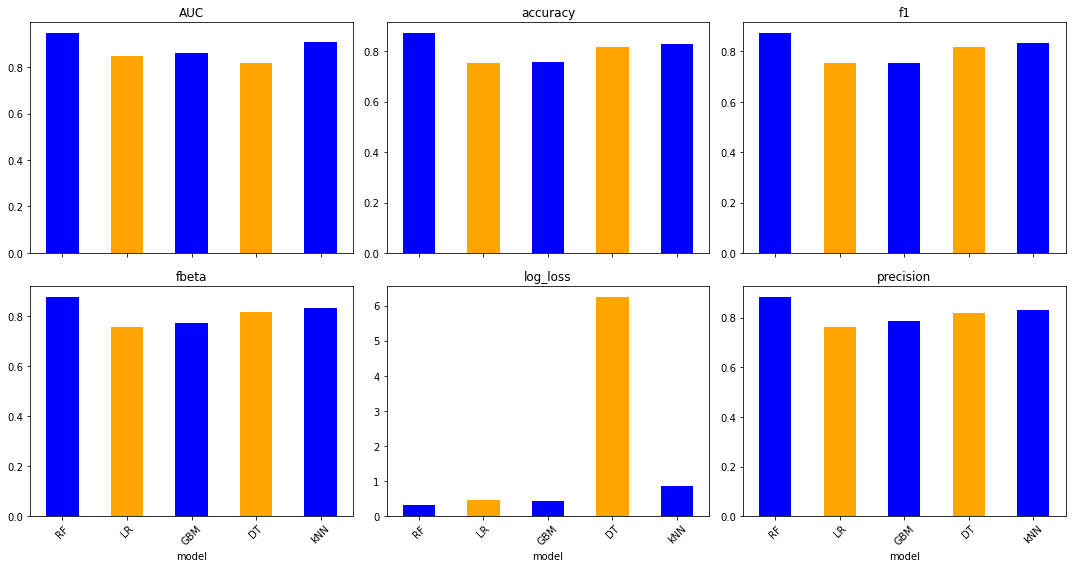

In [42]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
for (metric, group), ax in zip(metrics_forest_long.groupby("metric"), axes.flatten()):
    group.plot(x = 'model', 
               y = 'value', 
               kind = 'bar', 
               color = ["blue", "orange"],
               ax = ax, 
               title = metric,
               legend = None,
               sharex = True)
    ax.xaxis.set_tick_params(rotation = 45)
plt.tight_layout()
plt.show()

##### Because our target (round winners) is balanced, we will use accuracy as our metric to select the best model. Random forest performed the best in this regard - as well as most other ones, #####
#####  we will select it as our model for predicting round winners. #####

Text(0.5, 0, 'Relative Importance')

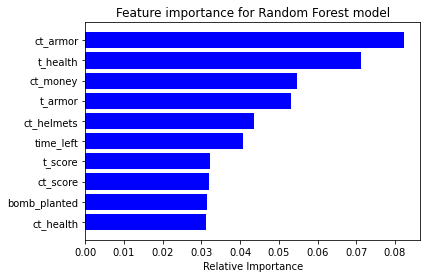

In [43]:
rounds_features = rounds.drop('round_winner', axis = 1)
features = rounds_features.columns
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[0:10][::-1]
plt.figure(1)
plt.title('Feature importance for Random Forest model')
plt.barh(range(len(top_indices)), importances[top_indices], color = 'b', align = 'center')
labels = features[top_indices]
labels = [ '\n'.join(wrap(l,13)) for l in labels ]
plt.yticks(range(len(top_indices)), labels)
plt.xlabel('Relative Importance')

Text(0.5, 0, 'Relative Importance')

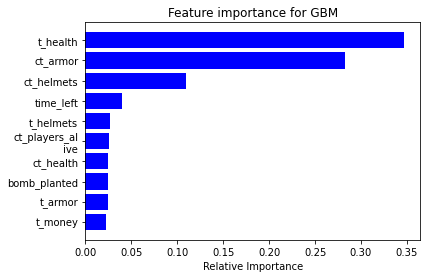

In [45]:
rounds_features = rounds.drop('round_winner', axis = 1)
features = rounds_features.columns
importances = gbm.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[0:10][::-1]
plt.figure(1)
plt.title('Feature importance for GBM')
plt.barh(range(len(top_indices)), importances[top_indices], color = 'b', align = 'center')
labels = features[top_indices]
labels = [ '\n'.join(wrap(l,13)) for l in labels ]
plt.yticks(range(len(top_indices)), labels)
plt.xlabel('Relative Importance')

[[15916  2113]
 [ 2635 16059]]


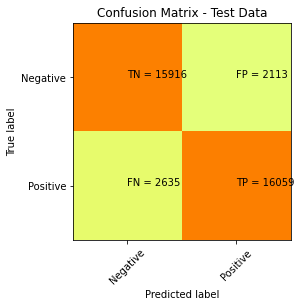

In [46]:
cm_forest = confusion_matrix(y_test, forest_y_predict)
print(cm_forest)

plt.imshow(cm_forest, interpolation = 'nearest', cmap = plt.cm.Wistia)
classNames = ['Negative', 'Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation = 45)
plt.yticks(tick_marks, classNames)
s = [['TN', 'FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j]) + " = " + str(cm_forest[i][j]))

C:\Users\cokeo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


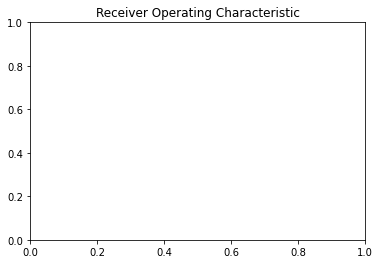

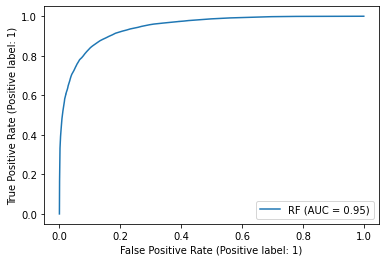

In [50]:
# Store FPR, TPR, and threshold as variables.
fpr, tpr, threshold = metrics.roc_curve(y_test, forest_y_predict)
# Store the AUC.
roc_auc = metrics.auc(fpr, tpr)
# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


C:\Users\cokeo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


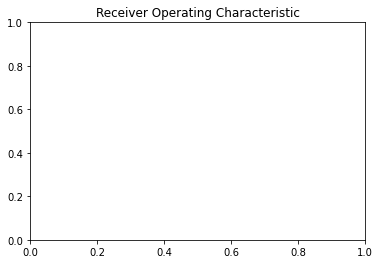

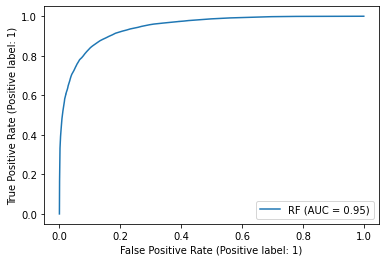

In [ ]:
plt.title('Receiver Operating Characteristic')
rf_roc = metrics.plot_roc_curve(forest,
                                   X_test,
                                   y_test,
                                   name = "RF")